100%|██████████| 500/500 [00:08<00:00, 61.10it/s]


Epoch: 0. Loss: 0.07111020386219025


100%|██████████| 500/500 [00:07<00:00, 65.43it/s]


Epoch: 1. Loss: 0.06358633935451508


100%|██████████| 500/500 [00:07<00:00, 65.69it/s]


Epoch: 2. Loss: 0.05922078713774681


100%|██████████| 500/500 [00:07<00:00, 65.07it/s]


Epoch: 3. Loss: 0.05363539233803749


100%|██████████| 500/500 [00:07<00:00, 65.38it/s]


Epoch: 4. Loss: 0.050720639526844025


100%|██████████| 500/500 [00:07<00:00, 65.95it/s]


Epoch: 5. Loss: 0.048256997019052505


100%|██████████| 500/500 [00:07<00:00, 65.81it/s]


Epoch: 6. Loss: 0.049815524369478226


100%|██████████| 500/500 [00:07<00:00, 66.37it/s]


Epoch: 7. Loss: 0.04975448176264763


100%|██████████| 500/500 [00:07<00:00, 65.09it/s]


Epoch: 8. Loss: 0.04462607949972153


100%|██████████| 500/500 [00:07<00:00, 66.60it/s]


Epoch: 9. Loss: 0.042249083518981934
Test Accuracy:  0.64


TypeError: 'other' must be an instance of matplotlib.axes._base._AxesBase, not a int

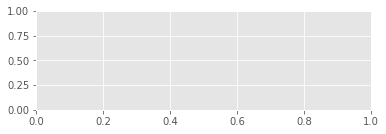

In [2]:
"""
This is a starter file to get you going. You may also include other files if you feel it's necessary.

Make sure to follow the code convention described here:
https://github.com/UWARG/computer-vision-python/blob/main/README.md#naming-and-typing-conventions

Hints:
* The internet is your friend! Don't be afraid to search for tutorials/intros/etc.
* We suggest using a convolutional neural network.
* TensorFlow Keras has the CIFAR-10 dataset as a module, so you don't need to manually download and unpack it.
"""

# Import whatever libraries/modules you need

from ast import arg
from matplotlib import style
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from re import L

from zmq import device


# Your working code here
REBUILD_DATA = False
device = torch.device("cuda:0")

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = np.dot(x_train, [0.299, 0.587, 0.114])
x_train = torch.Tensor(x_train) #play around with these since loss input n output rnt the same
x_train = x_train/255.0
x_test = np.dot(x_test, [0.299, 0.587, 0.114])
x_test = torch.Tensor(x_test) #play around with these since loss input n output rnt the same
x_test = x_test/255.0
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

ytrain = torch.zeros(50000, 10)
ytest = torch.zeros(10000, 10)

for i in range(50000):
    ytrain[i][(y_train[i] - 1).long()] = 1.0

for i in range(10000):
    ytest[i][(y_test[i] - 1).long()] = 1.0

y_train = ytrain
y_test = ytest

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        #x = torch.randn(32, 32).view(-1, 1, 32, 32)
        #self._to_linear = None
        #self.convs(x)
        nn.Flatten()
        self.fc1 = nn.Linear(800, 512)
        self.fc2 = nn.Linear(512, 10)
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        #if self._to_linear is None:
            #self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, 800)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim = 1)


net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()
MODEL_NAME = f"model-{int(time.time())}"

BATCH_SIZE = 100
EPOCHS = 10 

def train(net): 
    with open("model.log", "a") as f: 
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(x_train), BATCH_SIZE)): 
                x_batch = x_train[i:i+BATCH_SIZE].view(-1, 1, 32, 32)
                y_batch = y_train[i:i+BATCH_SIZE]
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                acc, loss = fwd_pass(x_batch, y_batch, train = True)
                if i % 10 == 0:
                    val_acc, val_loss = test(size = 100)
                    f.write(f"{MODEL_NAME}, {epoch}, {round(float(acc), 2)}, {round(float(loss), 4)}, {round(float(val_acc), 2)}, {round(float(val_loss), 4)}\n")
            print(f"Epoch: {epoch}. Loss: {loss}")

def batch_test(net): 
    with torch.no_grad():
        x_batch = x_test[:BATCH_SIZE].view(-1, 1, 32, 32)
        y_batch = y_test[:BATCH_SIZE]
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        net.zero_grad()
        outputs = net(x_batch)
        matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y_batch)]
        acc = matches.count(True)/len(matches) #add if statement
        print("Test Accuracy: ", round(acc, 3))

def fwd_pass(X, y, train = False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches) 
    loss = loss_function(outputs, y)
    if train: 
        loss.backward()
        optimizer.step()
    return acc, loss

def test(size = 32):
    X, y = x_test[:size], y_test[:size]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 32, 32).to(device), y.to(device))
    return val_acc, val_loss


train(net)
batch_test(net)

style.use("ggplot")
model_name = MODEL_NAME

def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")
    epochs = []
    accuracies = []
    losses = []
    test_accs = []
    test_losses = []
    for c in contents: 
        if model_name in c:
            name, epoch, acc, loss, test_acc, test_loss = c.split(",")
            epochs.append(float(epoch))
            accuracies.append(float(acc))
            losses.append(float(loss))
            test_accs.append(float(test_acc))
            test_losses.append(float(test_loss))
    fig = plt.figure()
    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex = ax1)
    ax1.plot(epochs, accuracies, label = "acc")
    ax1.plot(epochs, test_accs, label = "test_acc")
    ax1.legend(loc = 2)
    ax2.plot(epochs, losses, label = "loss")
    ax2.plot(epochs, test_losses, label = "test_loss")
    ax2.legend(loc = 2)
    plt.show() 

create_acc_loss_graph(model_name)


        

